In [1]:
state="TX"

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib

import warnings  # Suppress Warnings
warnings.filterwarnings('ignore')

_figsize=(10,7)

In [3]:
%%time
%run lib/startup.py S

sc_type= S
10.41.226.243
namespace= skondakindi
driver_host= 10.41.226.243


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/06/04 15:37:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
sparkContext= <SparkContext master=spark://spark-master-0.spark-headless.skondakindi.svc.cluster.local:7077 appName=myapp>

version of ipwidgets= 8.1.7
parquet_root= /home/skondakindi/public/Data/weather


measurements is a Dataframe (and table) with 12720632 records
stations is a Dataframe (and table) with 119503 records


weather is a Dataframe (and table) which is a join of measurements and stations with 12720632 records
CPU times: user 587 ms, sys: 105 ms, total: 691 ms
Wall time: 57.1 s


In [4]:
ms=['SNWD', 'PRCP', 'TOBS']
cms='or\n'.join(['Measurement="%s" '%(m) for m in ms])

##  read all data for state
Query="""
SELECT *
FROM weather
WHERE state="%s" and 
(%s)
"""%(state,cms)

In [5]:
weather_df=sqlContext.sql(Query)
print('number of rows in result=',weather_df.count())
weather_df.show(5)

number of rows in result= 171400


+-----------+-----------+----+--------------------+--------+---------+---------+----------+-------------------+-----+-------------+
|    Station|Measurement|Year|              Values|latitude|longitude|elevation|dist2coast|               name|state|      country|
+-----------+-----------+----+--------------------+--------+---------+---------+----------+-------------------+-----+-------------+
|US1TXAS0015|       PRCP|2022|[00 00 00 00 00 0...| 30.0341| -96.2209|     79.2|     122.5|  BELLVILLE 6.5 NNE|   TX|United States|
|US1TXBEL009|       PRCP|2022|[00 00 00 00 00 0...| 31.1231| -97.5284|    230.4|    280.75|      BELTON 5.4 NW|   TX|United States|
|US1TXBEL039|       PRCP|2022|[00 00 00 00 00 0...| 31.1861| -97.3422|    242.0|     278.0|     TEMPLE 6.2 NNE|   TX|United States|
|US1TXBEL055|       PRCP|2022|[00 00 00 00 00 0...| 31.1778| -97.3294|    235.0|     278.0|     TEMPLE 5.9 NNE|   TX|United States|
|US1TXBLC034|       PRCP|2022|[00 00 00 00 00 0...| 30.3582|  -98.319|    42

In [6]:
koppen_df = pd.read_csv("../../public/Data/Boosting_HW/Texas_Koppen.csv")
koppen_df

,Unnamed: 0,ID,Latitude,Longitude,Elevation,State,Name,GSN_Flag,HCN_CRN_Flag,WMO_ID,Koppen
0,83933,US1TXAC0002,33.8281,-98.5492,305.7,TX,WICHITA FALLS 5.2 SSW,NaN,NaN,NaN,Cfa
1,83934,US1TXAC0003,33.5838,-98.6298,323.7,TX,ARCHER CITY 0.7 SSW,NaN,NaN,NaN,Cfa
2,83935,US1TXAC0005,33.7762,-98.5350,300.2,TX,WICHITA FALLS 8.5 S,NaN,NaN,NaN,Cfa
3,83936,US1TXAC0009,33.8328,-98.5360,300.5,TX,WICHITA FALLS 4.6 SSW,NaN,NaN,NaN,Cfa
4,83937,US1TXAD0002,32.0533,-102.8796,973.5,TX,ANDREWS 26.7 SW,NaN,NaN,NaN,BSk
...,...,...,...,...,...,...,...,...,...,...,...
5386,117501,USW00093904,32.8167,-97.3500,214.9,TX,FT WORTH MEACHAM FLD NAAF,NaN,NaN,74739.0,Cfa
5387,117508,USW00093914,31.7831,-95.6039,141.7,TX,PALESTINE 2 NE,NaN,NaN,NaN,Cfa
5388,117513,USW00093928,32.7667,-96.7833,195.1,TX,DALLAS WBO,NaN,NaN,NaN,Cfa
5389,117521,USW00093985,32.7817,-98.0603,283.5,TX,MINERAL WELLS AP,NaN,NaN,NaN,Cfa


In [7]:
spark = (
    SparkSession.builder
        .appName("pandas-to-spark")
        .getOrCreate()
)

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

if not hasattr(pd.DataFrame, "iteritems"):
    # monkey-patch brings the alias back
    pd.DataFrame.iteritems = pd.DataFrame.items

koppen_sdf = spark.createDataFrame(koppen_df)

koppen_sdf.show(5)

+----------+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+------+
|Unnamed: 0|         ID|Latitude|Longitude|Elevation|State|                Name|GSN_Flag|HCN_CRN_Flag|WMO_ID|Koppen|
+----------+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+------+
|     83933|US1TXAC0002| 33.8281| -98.5492|    305.7|   TX|WICHITA FALLS 5.2...|    null|        null|  null|   Cfa|
|     83934|US1TXAC0003| 33.5838| -98.6298|    323.7|   TX| ARCHER CITY 0.7 SSW|    null|        null|  null|   Cfa|
|     83935|US1TXAC0005| 33.7762|  -98.535|    300.2|   TX| WICHITA FALLS 8.5 S|    null|        null|  null|   Cfa|
|     83936|US1TXAC0009| 33.8328|  -98.536|    300.5|   TX|WICHITA FALLS 4.6...|    null|        null|  null|   Cfa|
|     83937|US1TXAD0002| 32.0533|-102.8796|    973.5|   TX|     ANDREWS 26.7 SW|    null|        null|  null|   BSk|
+----------+-----------+--------+---------+---------+-----+-----

In [8]:
from pyspark.sql.functions import col

weather_df = weather_df.withColumn("Station", col("Station").cast("string"))
koppen_sdf = koppen_sdf.withColumn("ID", col("ID").cast("string"))

weather_df = weather_df.withColumnRenamed("Station", "station_id")
koppen_sdf = koppen_sdf.withColumnRenamed("ID", "station_id")

In [9]:
valid_station_ids = koppen_df['ID'].unique().tolist()

tobs_df = weather_df.filter((weather_df.Measurement=="TOBS") & (weather_df.station_id.isin(valid_station_ids)))
snwd_df = weather_df.filter((weather_df.Measurement=="SNWD") & (weather_df.station_id.isin(valid_station_ids)))
prcp_df = weather_df.filter((weather_df.Measurement=="PRCP") & (weather_df.station_id.isin(valid_station_ids)))

In [10]:
from __future__ import annotations
import numpy as np
from typing import Union, ByteString

def decode_and_average(
    data: Union[ByteString, memoryview, np.ndarray],
    *,
    dtype: np.dtype = np.int16,
    low: int = -200,
    high: int = 1000
) -> np.ndarray:
    """
    Decode a raw byte/array payload to `dtype`, clip out-of-range values,
    and return a z-scored NumPy array.

    Parameters
    ----------
    data : bytes | bytearray | memoryview | np.ndarray
        The raw buffer (or already-decoded NumPy array) to process.
    dtype : np.dtype, default ``np.int16``
        Target dtype for decoding.  Must match the true encoding.
    low, high : int, default (-200, 1000)
        Inclusive limits outside of which values are considered invalid.

    Returns
    -------
    np.ndarray
        *Shape and dtype preserved.*  
        • If the entire payload is invalid, an array of zeros is returned.  
        • Otherwise the array is mean-centered and scaled to unit variance.
    """
    # Convert to ndarray with **zero copies** when possible
    if isinstance(data, np.ndarray):
        arr = data.astype(dtype, copy=False)
    else:              # bytes, bytearray, memoryview …
        arr = np.frombuffer(data, dtype=dtype)

    # Mask the invalid range
    mask = (arr < low) | (arr > high)
    if mask.all():
        # All values invalid → return zeros (float for downstream math safety)
        return np.zeros(arr.shape, dtype=float)

    # Compute mean & std on the valid slice only
    valid = arr[~mask].astype(float)
    mean = valid.mean()
    std = valid.std()

    # Standardize; fall back to simple centering when std == 0
    result = (arr.astype(float) - mean) if std == 0 else (arr.astype(float) - mean) / std

    # Keep overall shape; preserve NaN for the positions that were masked
    result[mask] = np.nan
    return result

In [11]:
import numpy as np
from sklearn.decomposition import PCA
from functools import reduce
from typing import Dict, List, Sequence, Tuple

Array  = np.ndarray
Key    = Tuple[str, int]            # (station_id, year)
Matrix = Tuple[List[Key], Array]    # (keys, matrix or pca result)


def _build_matrix(
    spark_df,
    decode_fn,
) -> Matrix:
    """
    → keys  : [(station_id, year), …]     len == n_samples
    → matrix: np.ndarray shape (n_samples, 366)
    """
    rows = (spark_df
            .rdd
            .map(lambda r: (r.station_id, r.Year, decode_fn(r.Values)))
            .collect())

    keys   = [(sid, yr) for sid, yr, _ in rows]
    matrix = np.vstack([vec for _, _, vec in rows])
    matrix = np.nan_to_num(matrix, nan=0.0)          # replace NaNs with 0
    return keys, matrix


def _pca(matrix: Array, n_components: int = 3, *, seed: int = 42) -> Array:
    """Wrapper that always returns a (n_samples, n_components) matrix."""
    return PCA(n_components=n_components, random_state=seed).fit_transform(matrix)


def process_measurement(
    spark_df,
    decode_fn,
    n_components: int = 3,
    *,
    seed: int = 42,
) -> Matrix:
    """Decode, clean, run PCA, return (keys, pca_matrix)."""
    keys, M = _build_matrix(spark_df, decode_fn)
    return keys, _pca(M, n_components, seed=seed)


In [12]:
joins_tobs, tobs_pca = process_measurement(tobs_df,  decode_and_average)
joins_snwd, snwd_pca = process_measurement(snwd_df,  decode_and_average)
joins_prcp, prcp_pca = process_measurement(prcp_df,  decode_and_average)

In [13]:
dicts: Sequence[Dict[Key, Array]] = [
    {k: v for k, v in zip(joins_tobs, tobs_pca)},
    {k: v for k, v in zip(joins_snwd, snwd_pca)},
    {k: v for k, v in zip(joins_prcp, prcp_pca)},
]

common_keys = reduce(set.intersection, (set(d) for d in dicts))
n_features  = sum(p.shape[1] for p in (tobs_pca, snwd_pca, prcp_pca))

X = np.empty((len(common_keys), n_features))
for i, key in enumerate(common_keys):
    X[i] = np.hstack([d[key] for d in dicts])

# keeping the keys for later joins if necessary
final_keys = list(common_keys)

In [14]:
feature_cols = [f"{m}_{i}"
                for m in ("TOBS", "SNWD", "PRCP")
                for i in range(1, 4)]

df_final = pd.DataFrame(X, columns=feature_cols)

# unpack keys → two extra columns
keys_arr = np.asarray(final_keys, dtype=object)      # shape (n_samples, 2)
df_final["station_id"] = keys_arr[:, 0]
df_final["year"]       = keys_arr[:, 1].astype(int)

In [15]:
koppen_df_clean = (
    koppen_df[["ID", "Koppen"]]        # keep only what we need
      .rename(columns={"ID": "station_id"})
)

df_final_with_labels = (
    df_final
      .merge(koppen_df_clean, on="station_id", how="inner")
)

print(df_final_with_labels.head())

     TOBS_1    TOBS_2    TOBS_3    SNWD_1    SNWD_2   SNWD_3    PRCP_1  \
0 -1.214594  0.696746 -1.583781 -0.220516 -0.225016 -0.18624 -0.293254   
1 -1.829101  0.148525  2.251975 -0.220516 -0.225016 -0.18624 -0.867830   
2 -0.555854  0.665180  1.677259 -0.220516 -0.225016 -0.18624  0.998790   
3  8.197500  4.267913 -1.628339 -0.220516 -0.225016 -0.18624 -1.295066   
4 -1.488594  2.183347 -0.917223 -0.220516 -0.225016 -0.18624 -0.934946   

     PRCP_2    PRCP_3   station_id  year Koppen  
0  0.975490  2.433447  USC00415579  2018    BSh  
1  0.299103 -0.665492  USC00415579  1965    BSh  
2 -1.064510 -0.095306  USC00415579  1941    BSh  
3  0.072391  0.048279  USC00415579  1945    BSh  
4  0.550973  0.038974  USC00415579  2002    BSh  


## XGBoost

In [26]:
f'Version of xgb={xgb.__version__}, should be at least 1.5.1'

'Version of xgb=2.1.4, should be at least 1.5.1'

### Trial 1

In [27]:
# Prepare feature matrix X and label vector y

import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Drop ID columns, extract features and labels
df_ml = df_final_with_labels.drop(columns=["station_id", "year"])
X      = df_ml.drop(columns="Koppen").values         # shape: (n_samples, 9)
y_raw  = df_ml["Koppen"].values                       # string labels

# Encode Köppen strings → integer classes (0, 1, …, C-1)
le = LabelEncoder()
y  = le.fit_transform(y_raw)                         # e.g. ['A','B','C','A'] → [0,1,2,0]

n_classes = len(le.classes_)                         # number of unique Köppen labels

In [28]:
# Create 50% train, 25% validation, 25% test splits (stratified)

# First split off 50% as “train”, 50% as “temp”
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.50, stratify=y, random_state=42
)

# Now split the “temp” set 50/50 → 25% total each for validation & test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print("Shapes →",
      f"Train:   {X_train.shape}, {y_train.shape};",
      f"Val:     {X_val.shape},   {y_val.shape};",
      f"Test:    {X_test.shape},  {y_test.shape}")


Shapes → Train:   (13126, 9), (13126,); Val:     (6563, 9),   (6563,); Test:    (6563, 9),  (6563,)


In [29]:
# Wrap arrays into DMatrix for XGBoost

dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val,   label=y_val)
dtest  = xgb.DMatrix(X_test,  label=y_test)

In [30]:
# Sweep tree depths 1 → 4, use early stopping on validation logloss

depth_results = {}
num_round       = 1000      # upper bound on # of trees
early_stop_rounds = 25      # if no improvement in 25 rounds on validation

for depth in [1, 2, 3, 4]:
    print(f"\nTree Depth {depth}")
    
    # Define parameters (multi-class)
    param = {
        'max_depth':   depth,
        'eta':         0.3,                    # shrinkage
        'verbosity':   0,                      # 0 = silent
        'objective':   'multi:softprob',       # multi-class logloss
        'num_class':   n_classes,
        'eval_metric': 'mlogloss',
        'nthread':     7
    }
    
    # Train with early stopping on validation
    evals = [(dtrain, 'train'), (dval, 'validation')]
    
    bst = xgb.train(
        params                 = param,
        dtrain                 = dtrain,
        num_boost_round        = num_round,
        evals                   = evals,
        early_stopping_rounds  = early_stop_rounds,
        verbose_eval          = False       # suppress per-iteration prints
    )
    
    # 4c)  Record best iteration and accuracies
    best_iter = bst.best_iteration
    # Predict class labels on train & val
    y_train_pred = np.argmax(bst.predict(dtrain), axis=1)
    y_val_pred   = np.argmax(bst.predict(dval),   axis=1)
    train_acc    = accuracy_score(y_train, y_train_pred)
    val_acc      = accuracy_score(y_val,   y_val_pred)
    
    depth_results[depth] = {
        'model':     bst,
        'best_iter': best_iter,
        'train_acc': train_acc,
        'val_acc':   val_acc
    }
    
    print(f"  → Best Iteration: {best_iter:3d};  "
          f"Train Acc = {train_acc:.3f};  Val Acc = {val_acc:.3f}")


Tree Depth 1
  → Best Iteration: 216;  Train Acc = 0.725;  Val Acc = 0.724

Tree Depth 2
  → Best Iteration: 127;  Train Acc = 0.744;  Val Acc = 0.732

Tree Depth 3
  → Best Iteration:  69;  Train Acc = 0.757;  Val Acc = 0.733

Tree Depth 4
  → Best Iteration:  55;  Train Acc = 0.777;  Val Acc = 0.732


In [31]:
# Choose the depth with highest validation accuracy (tie → smaller depth)

best_depth = max(
    depth_results,
    key=lambda d: (depth_results[d]['val_acc'], -d)
)
best_model = depth_results[best_depth]['model']

print(f"\nSelected tree depth = {best_depth} "
      f"(val_acc = {depth_results[best_depth]['val_acc']:.3f})")



Selected tree depth = 3 (val_acc = 0.733)


Test Accuracy = 0.728   →   Test Error = 0.272


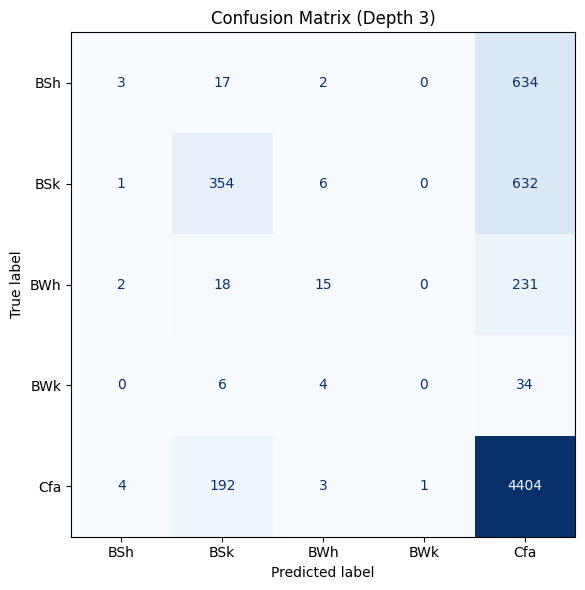

In [32]:
# Final evaluation on the TEST set

# Predict on test
y_test_pred = np.argmax(best_model.predict(dtest), axis=1)
test_acc    = accuracy_score(y_test, y_test_pred)
test_error  = 1.0 - test_acc

print(f"Test Accuracy = {test_acc:.3f}   →   Test Error = {test_error:.3f}")

# 6b)  Confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=range(n_classes))
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title(f"Confusion Matrix (Depth {best_depth})")
plt.tight_layout()
plt.show()


---
### Trial 2

In [33]:
df_ml = df_final_with_labels.drop(columns=["station_id", "year"])
X      = df_ml.drop(columns="Koppen").values                      # (n_samples, 9)
y_raw  = df_ml["Koppen"].values

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y_raw)                                       # int-encoded labels

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.50, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

In [35]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

depth_results = {}

for depth in [1, 2, 3, 4]:
    clf = xgb.XGBClassifier(
        objective       = "multi:softprob",
        num_class       = len(le.classes_),
        max_depth       = depth,
        learning_rate   = 0.10,
        n_estimators    = 1_000,
        eval_metric     = "mlogloss",
        random_state    = 42,
        n_jobs          = -1,
    )
    
    clf.fit(
        X_train, y_train,
        eval_set              = [(X_train, y_train), (X_val, y_val)],
        verbose               = False,
    )
    
    depth_results[depth] = {
        "model"          : clf,
        "train_acc"      : accuracy_score(y_train, clf.predict(X_train)),
        "val_acc"        : accuracy_score(y_val,   clf.predict(X_val)),
    }
    
    print(f"Depth {depth:>2} | "
          f"train_acc={depth_results[depth]['train_acc']:.3f} | "
          f"val_acc={depth_results[depth]['val_acc']:.3f}")

Depth  1 | train_acc=0.726 | val_acc=0.724
Depth  2 | train_acc=0.757 | val_acc=0.731
Depth  3 | train_acc=0.810 | val_acc=0.730
Depth  4 | train_acc=0.879 | val_acc=0.728


In [36]:
best_depth = max(depth_results, key=lambda d: (depth_results[d]["val_acc"], -d))
best_clf   = depth_results[best_depth]["model"]

print(f"\n Chosen depth = {best_depth} "
      f"with validation accuracy {depth_results[best_depth]['val_acc']:.3f}")


 Chosen depth = 2 with validation accuracy 0.731


Test accuracy = 0.727  (error rate = 0.273)


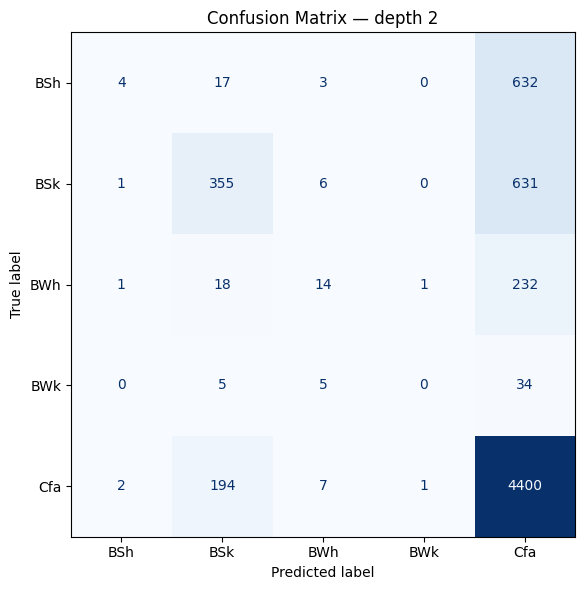

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

y_test_pred = best_clf.predict(X_test)
test_acc    = accuracy_score(y_test, y_test_pred)

print(f"Test accuracy = {test_acc:.3f}  (error rate = {1-test_acc:.3f})")

cm = confusion_matrix(y_test, y_test_pred, labels=range(len(le.classes_)))
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title(f"Confusion Matrix — depth {best_depth}")
plt.tight_layout()
plt.show()